# solving with masks

In [1]:
import scipy.io
import numpy as np
import pylops
import matplotlib.pyplot as plt

from scipy.sparse.linalg import lsqr
from pylops.optimization.sparsity import *
plt.close('all')

In [2]:
# load the data
mat = scipy.io.loadmat('GulfOfSuez128.mat')
data = mat["D"]
D = data[:, :, 63]
D_sqz = D.reshape(-1,order = 'C')
nt,nr = D.shape
N = nt*nr
scail = np.sqrt(1./np.prod((nt,nr)))

Text(0.5, 1.0, 'Original data')

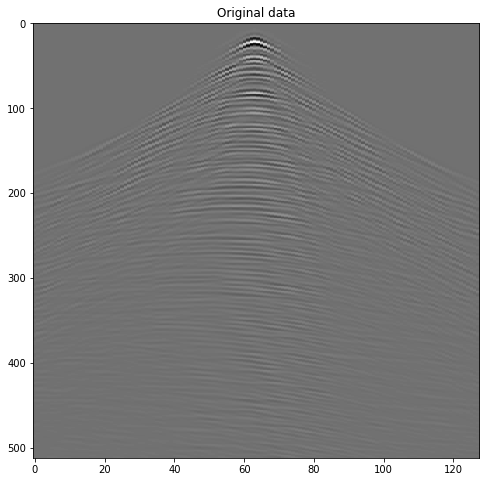

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(D,cmap='gray',aspect='auto')
ax.set_title('Original data')

In [4]:
# frqeuncy spectrum
F = pylops.signalprocessing.FFT2D(dims=(nt,nr),nffts=(nt,nr))

# Here cannot use reshape in column-wise, which is different from that of Matlab
fre = F*D.flatten()
D_adjF = F.H*fre

fre = (fre.reshape(nt, nr,order='C')) # undo the scailing
fre_shift = np.fft.fftshift(fre)

fre_np = np.fft.fftshift(np.fft.fft2(D))
fre_np_sqz = fre_np.reshape(-1,order='C')

# Jitterred subsampling

In [5]:
# relocation sampling(curvatural focus)
# focus zone [40 80]
s_min = 40
s_max= 80

interval_d = 2
interval_s = 6
node_s1 = np.arange(0,s_min,interval_s)
node_s2 = np.arange(s_max,nr,interval_s)
node_d = np.arange(s_min,s_max,interval_d)
jitter_s1 = np.random.randint(interval_s,size=node_s1.size)
jitter_s1[-1] = np.random.randint(s_min - node_s1[-1])
jitter_s2 = np.random.randint(interval_s,size=node_s2.size)
jitter_s2[-1] = np.random.randint(nr - node_s2[-1])
jitter_d = np.random.randint(interval_d,size=node_d.size)
jitter_d[-1] = np.random.randint(s_max - node_d[-1])

jitter = np.concatenate((node_s1+jitter_s1,node_d+jitter_d,node_s2+jitter_s2,),axis=None)

cod = np.arange(0,nt*nr).reshape(nt,nr)
idx = cod[:,jitter].flatten()

R = pylops.Restriction(N, idx)
D_dec = R*D_sqz
D_adj = R.H*D_dec

Text(0.5, 1.0, 'Adjoint recovery')

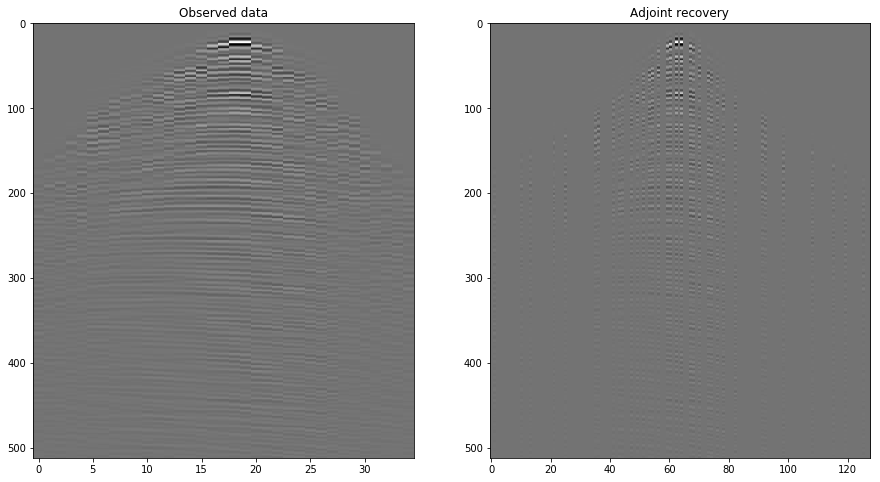

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(D_dec.reshape(nt,jitter.size,order='C'),cmap='gray',aspect='auto')
axs[0].set_title('Observed data')
axs[1].imshow(D_adj.reshape(nt,nr,order='C'),cmap='gray',aspect='auto')
axs[1].set_title('Adjoint recovery')

# Calculating derivatives

In [7]:
# calculate derivatives
# by hand
fre_sqz = fre.reshape(-1,order='C')

dx=10
kn=1/(2*dx)
dk=2*kn/nr
ks = np.arange(-kn,kn,dk)
ka = np.where(ks>0)
ka = ka[0]
ks_pos = ks[ka[0]:]
ks_neg = ks[0:ka[0]]
ks = np.concatenate((ks_pos,ks_neg))

dt=5e-3
fn=1/(2*dt)

coeff1 = 1j*2*np.pi*ks
coeff2 = -(2*np.pi*ks)**2

coeff1_m = np.tile(coeff1,nt)
coeff2_m = np.tile(coeff2,nt)

D1op_hand = pylops.Diagonal(coeff1_m)
D2op_hand = pylops.Diagonal(coeff2_m)

D1_hand_fre = D1op_hand*fre_sqz
D2_hand_fre = D2op_hand*fre_sqz

D1_hand = F.H*D1_hand_fre
D2_hand = F.H*D2_hand_fre


## making a mask in Fourier domain

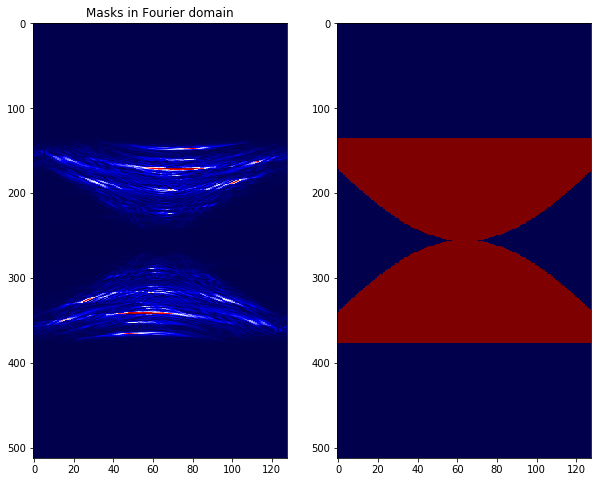

In [8]:
fre = np.abs(F*D.flatten())
mat =fre.reshape(nt,nr)
x1 = np.arange(62)
x2 = np.arange(62,128)
t3 = np.sqrt(256**2 + 1.5* ((64-x1)/0.35)**2)
t4 = np.sqrt(256**2 + 1.5* ((x2-64)/0.35)**2)
t_vec1 = np.concatenate((t3,t4),axis=None)
mask_1 = np.zeros((nt,nr))
for i in np.arange(nr):
    mask_1[int(t_vec1[i]):377,i] = 1
    mask_1[135:256,i] = np.flip(mask_1[256:377,i],axis=0)
mask_f = np.fft.ifftshift(mask_1) # inverse fftshift to make the right position
mask_fre = pylops.Diagonal(mask_f)

fig,axes = plt.subplots(1,2,figsize=(10,8))
axes[0].imshow(np.fft.fftshift(np.abs(fre).reshape(nt,nr)),cmap='seismic',aspect='auto')
axes[0].set_title('Masks in Fourier domain')
axes[1].imshow(mask_1,cmap='seismic',aspect='auto')

## making mask in time-space domain

Text(0.5, 1.0, 'Mask in time domain(smoothing)')

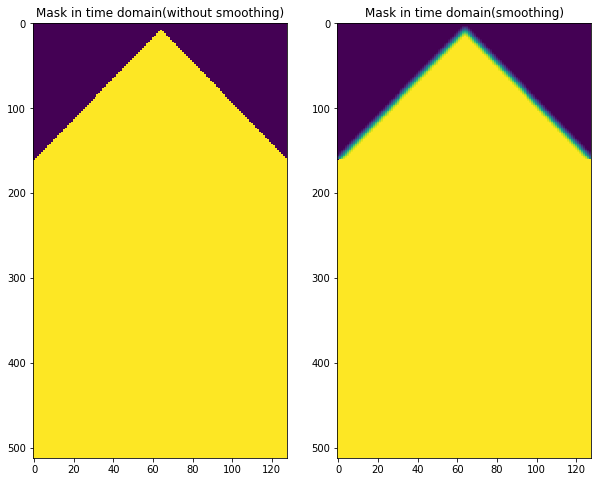

In [9]:
x1 = np.arange(64)
x2 = np.arange(64,128)
t1 = (64-x1)*2.4
t2 = (x2-64)*2.4
t_vec = np.concatenate((t1,t2),axis=None) + 8
mask_2 = np.zeros((nt,nr))
for i in np.arange(nr):
    mask_2[int(t_vec[i]):nt,i] = 1

Sop_t = pylops.Smoothing2D(nsmooth=[11, 3], dims=[nt, nr])
mask_2s = Sop_t*mask_2.flatten()
mask_2s = mask_2s.reshape(nt,nr)
mask_2s[160:nt,:] = mask_2[160:nt,:]

mask_time = pylops.Diagonal(mask_2s)
test_t = mask_time*D_sqz
test_t = test_t.reshape(nt,nr)
fig,axes = plt.subplots(1,2,figsize=(10,8))
axes[0].imshow(mask_2,aspect='auto')
axes[0].set_title('Mask in time domain(without smoothing)')
im2 = axes[1].imshow(mask_2s.reshape(nt,nr),aspect='auto')
axes[1].set_title('Mask in time domain(smoothing)')

# Construction & solving of the linear system

In [10]:
# solve the linear equations
D2_dec = np.real(R*(D2_hand))
D1_dec = np.real(R*(D1_hand))

# solve in time domain

# with masks on time & frequency domain
Forward = pylops.VStack([R*mask_time*F.H*mask_fre, R*mask_time*F.H*D1op_hand*mask_fre, R*mask_time*F.H*D2op_hand*mask_fre])
rhs = np.concatenate((D_dec, D1_dec, D2_dec), axis=0)

# with masks on frequency domain
Forward2 = pylops.VStack([R*F.H*mask_fre, R*F.H*D1op_hand*mask_fre, R*F.H*D2op_hand*mask_fre])
rhs2 = np.concatenate((D_dec, D1_dec, D2_dec), axis=0)


In [11]:
xinv, pspgl, info = SPGL1(Forward, rhs,returninfo=True, 
                             **dict(iterations=600))

sigma = np.linalg.norm(rhs - (Forward*xinv))

# xinv2, pspgl2, info2 = SPGL1(Forward2, rhs2,returninfo=True, 
#                              **dict(iterations=1000))
xinv2 = \
    pylops.optimization.leastsquares.RegularizedInversion(Forward, [], rhs, 
                                                          **dict(damp=0, iter_lim=600, show=1))

sigma2 = np.linalg.norm(rhs2 - (Forward2*xinv2))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pylops/basicoperators/Restriction.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iava] = x
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pylops/optimization/spgl1/spgl_aux.py:130: RuntimeWarning: invalid value encountered in true_divide
  xc  = xc / xa


 
LSQR            Least-squares solution of  Ax = b
The matrix A has    53760 rows  and    65536 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      600
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.258e+03  3.258e+03    1.0e+00  3.0e-04
     1  6.30210e-01   6.730e+02  6.730e+02    2.1e-01  6.1e-01   9.8e-01  1.0e+00
     2  5.29269e-01   4.054e+02  4.054e+02    1.2e-01  2.2e-01   1.2e+00  2.1e+00
     3  2.61662e-01   3.689e+02  3.689e+02    1.1e-01  1.6e-01   1.4e+00  3.3e+00
     4  3.87130e-01   3.161e+02  3.161e+02    9.7e-02  2.1e-01   1.6e+00  5.8e+00
     5  1.25467e+00   2.548e+02  2.548e+02    7.8e-02  1.7e-01   1.8e+00  8.9e+00
     6  2.39405e+00   2.243e+02  2.243e+02    6.9e-02  1.0e-01   1.9e+00  1.1e+01
     7  3.30557e+00   2.136e+02  2.136e+02    6.6e-02  6.2e-02   2.1e+00  1.3e+01
     8  3.77837e+00   2.086e

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/lsqr.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])


   590  1.08397e+01   1.992e+02  1.992e+02    6.1e-02  4.7e-06   1.0e+03  2.2e+05
   591  1.08405e+01   1.992e+02  1.992e+02    6.1e-02  4.7e-06   1.0e+03  2.2e+05
   592  1.08414e+01   1.992e+02  1.992e+02    6.1e-02  4.7e-06   1.0e+03  2.2e+05
   593  1.08422e+01   1.992e+02  1.992e+02    6.1e-02  4.7e-06   1.0e+03  2.2e+05
   594  1.08430e+01   1.992e+02  1.992e+02    6.1e-02  4.7e-06   1.0e+03  2.2e+05
   595  1.08438e+01   1.992e+02  1.992e+02    6.1e-02  4.7e-06   1.0e+03  2.3e+05
   596  1.08446e+01   1.992e+02  1.992e+02    6.1e-02  4.6e-06   1.0e+03  2.3e+05
   597  1.08454e+01   1.992e+02  1.992e+02    6.1e-02  4.6e-06   1.0e+03  2.3e+05
   598  1.08462e+01   1.992e+02  1.992e+02    6.1e-02  4.6e-06   1.0e+03  2.3e+05
   599  1.08470e+01   1.992e+02  1.992e+02    6.1e-02  4.6e-06   1.0e+03  2.3e+05
   600  1.08478e+01   1.992e+02  1.992e+02    6.1e-02  4.6e-06   1.0e+03  2.3e+05
 
LSQR finished
The iteration limit has been reached                      
 
istop =       7   r1n

In [13]:
print("sigma1=",sigma)
print("sigma2=",sigma2)
print(info)
# print(info2)


sigma1= 455.1375472665929
sigma2= 416.7893287812777
{'tau': 548929458.9779418, 'rNorm': 455.1375472665929, 'rGap': 234.95834386658552, 'gNorm': 0.04390356390480295, 'stat': 5, 'iterr': 599, 'nProdA': 0, 'nProdAt': 0, 'nNewton': 220, 'timeProject': 0, 'timeMatProd': 0, 'itnLSQR': 0, 'options': {'fid': 1, 'verbosity': 2, 'iterations': 600, 'nPrevVals': 3, 'bpTol': 1e-06, 'lsTol': 1e-06, 'optTol': 0.0001, 'decTol': 0.0001, 'stepMin': 1e-16, 'stepMax': 100000.0, 'rootMethod': 2, 'activeSetIt': inf, 'subspaceMin': 0, 'iscomplex': nan, 'maxMatvec': inf, 'weights': 1, 'project': <function NormL1_project at 0x10d0628c8>, 'primal_norm': <function NormL1_primal at 0x10d062950>, 'dual_norm': <function NormL1_dual at 0x10d0629d8>}, 'xNorm1': array([     0.        ,   2346.96740294,  75102.9568942 ,  75102.9568942 ,
        75102.9568942 ,  75102.9568942 ,  75102.95689419,  75102.9568942 ,
        75102.9568942 ,  75102.95689419,  75102.9568942 ,  75102.9568942 ,
        75102.9568942 ,  75102.9568

In [14]:
xinv = np.real(mask_time*F.H*mask_fre*xinv).reshape(nt,nr)
xinv2 = np.real(F.H*mask_fre*xinv2).reshape(nt,nr)

xinv_fre = np.fft.fftshift(np.fft.fft2(xinv))
xinv2_fre = np.fft.fftshift(np.fft.fft2(xinv2))

relative = np.abs((xinv - D) / np.amax(D))
relative2 = np.abs((xinv2 - D) / np.amax(D))

relative_fre = np.abs((xinv_fre - fre_np) / np.amax(fre_np))
relative2_fre = np.abs((xinv2_fre - fre_np) / np.amax(fre_np))

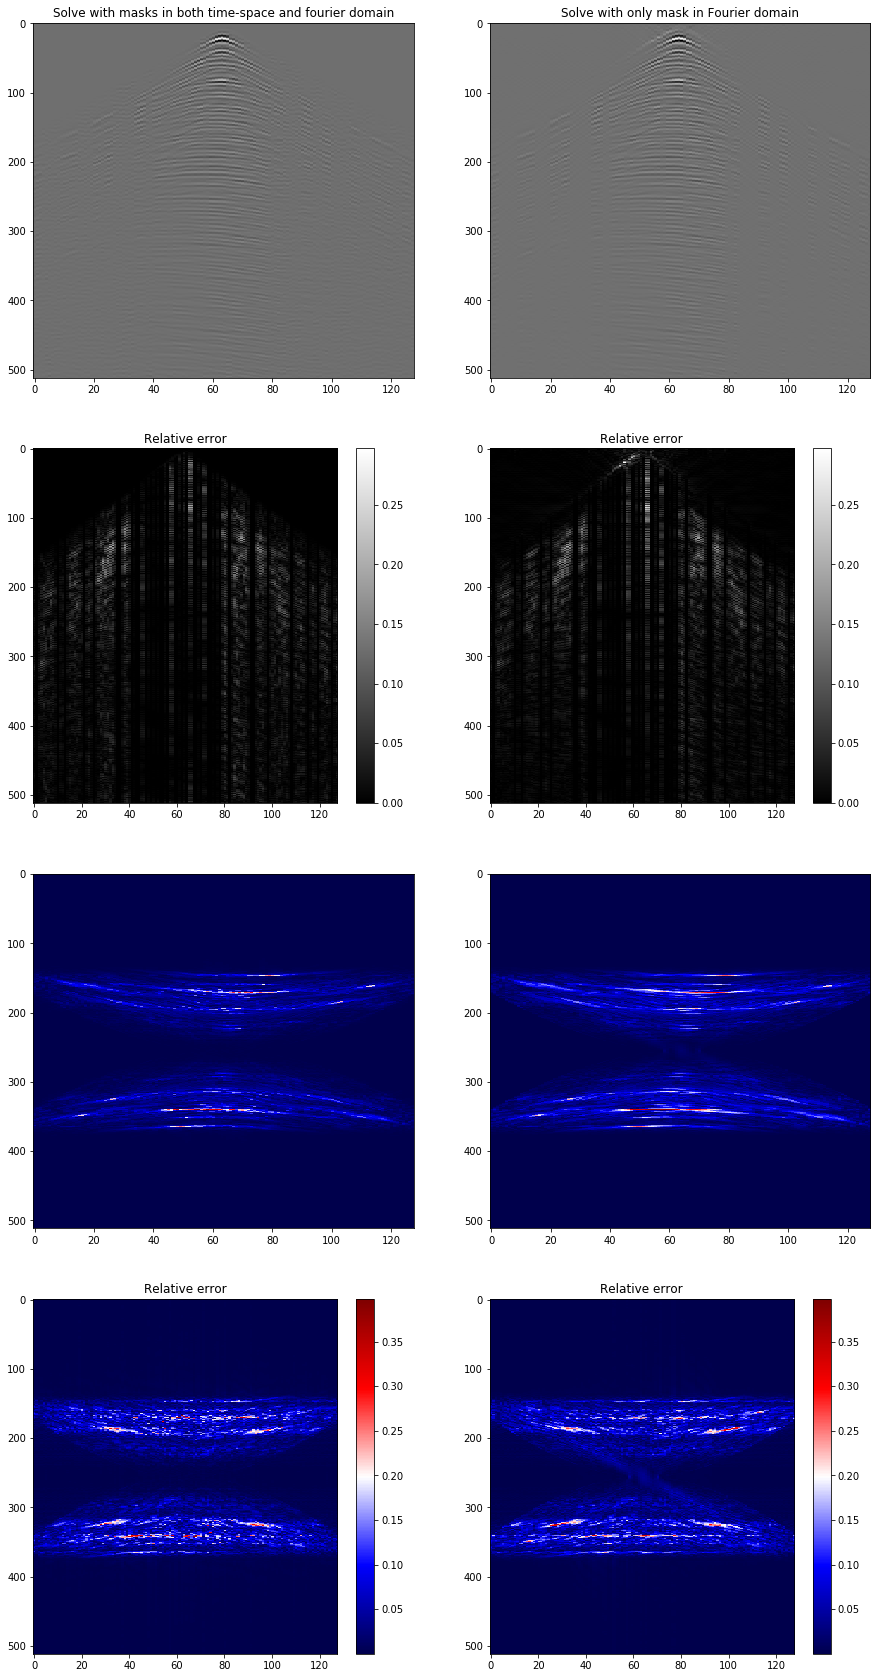

In [15]:
combined_data = np.array([relative,relative2])
t_min, t_max = np.amin(combined_data), np.amax(combined_data)

combined_data = np.array([relative_fre,relative2_fre])
f_min, f_max = np.amin(combined_data), np.amax(combined_data)

fig, axs = plt.subplots(4, 2, figsize=(15, 30))
axs[0,0].imshow(np.real(xinv),cmap='gray',aspect='auto')
axs[0,0].set_title('Solve with masks in both time-space and fourier domain')
axs[0,1].imshow(np.real(xinv2),cmap='gray',aspect='auto')
axs[0,1].set_title('Solve with LSQR')
im1 = axs[1,0].imshow(relative,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
im2 = axs[1,1].imshow(relative2,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
fig.colorbar(im1,ax=axs[1,0])
fig.colorbar(im2,ax=axs[1,1])
axs[1,0].set_title('Relative error')
axs[1,1].set_title('Relative error')
axs[2,0].imshow(np.abs(xinv_fre),cmap='seismic',aspect='auto')
axs[2,1].imshow(np.abs(xinv2_fre),cmap='seismic',aspect='auto')
im3 = axs[3,0].imshow(relative_fre,cmap='seismic',aspect='auto',vmin=f_min, vmax =f_max)
im4 = axs[3,1].imshow(relative2_fre,cmap='seismic',aspect='auto',vmin=f_min, vmax =f_max)
axs[3,0].set_title('Relative error')
axs[3,1].set_title('Relative error')
fig.colorbar(im3,ax=axs[3,0])
fig.colorbar(im4,ax=axs[3,1])